# Rope Positional Embedding

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding
T = 2047
D = 4
rope = RopeEmbedding(D, 2048)

In [ ]:
import torch

q = torch.zeros(2, 4, T, D)
k = torch.zeros(2, 4, T, D)

q[:, :, :, -4:] = torch.tensor([[1., 0., 0., 1.]])
k[:, :, :, -4:] = torch.tensor([[1., 0., 0., 1.]])
rq, rk = rope(q, k)

In [ ]:
q_odd, q_even = q[..., ::2], q[..., 1::2]
qJ = torch.stack([-q_even, q_odd], dim=-1).reshape_as(q)

q_rot = (q * rope.cos_emb[...,:T,:]) + (qJ * rope.sin_emb[...,:T,:])
plt.plot(q_rot[0,0,:,-4], q_rot[0,0,:,-3], 'x')
# plt.plot(q_rot[0,0,:512,-2], q_rot[0,0,:512,-1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding
from Dreamers.models.transformers.blocks import MultiHeadAttention

n_dim = 128
n_heads = 8
rope = RopeEmbedding(n_dim//n_heads, 2048)
attention = MultiHeadAttention(n_dim, n_heads, rope=rope)
x = torch.rand(32, 16, n_dim)
Y, A = attention(x, x, x)

In [ ]:
dim = 2
ndim = 5 # B, D1, D2, D3, D
range(1, dim), dim, range(dim+1, ndim)

# Creating the Masks

In [ ]:
import torch
import matplotlib.pyplot as plt
from Dreamers.models.transformers.utils import create_temporal_mask, create_encoder_spatial_mask, create_decoder_spatial_mask
mask = create_temporal_mask(5)
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.figure()
mask = create_encoder_spatial_mask(8, 1)
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.figure()
mask = create_decoder_spatial_mask(8, 1)
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.figure()

# Verifying the Attention Patterns

In [ ]:
from Dreamers.models.transformers.blocks import AxialAttention, Attention
n_dim = 128
n_heads = 8
T = 100
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=True,dropout_prob=0.0)
x1 = torch.rand(1, T, n_dim)
x2 = torch.rand(1, T, n_dim)
x2[:, 50:, :] = x1[:, 50:, :] # Change of the end tokens only and see if that changes the output of the earlier tokens
mask = create_temporal_mask(T, device=x1.device)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mask.cpu().numpy(), cmap='gray')

In [ ]:

Y1 = attention(x1, x1, x1, mask=mask)
Y2 = attention(x2, x2, x2, mask=mask)
# The outputs after the change point should be identical
torch.allclose(Y1[:, 50:, :], Y2[:, 50:, :])

In [ ]:
import torch
import matplotlib.pyplot as plt
from Dreamers.models.transformers.blocks import AxialAttention, Attention
from Dreamers.models.transformers.utils import create_temporal_mask, create_encoder_spatial_mask, create_decoder_spatial_mask
n_dim = 128
n_heads = 8
T = 3 
N_patch = 16
N_latents = 4

temporal_mask = create_temporal_mask(T)
spatial_mask_enc = create_encoder_spatial_mask(N_patch, N_latents)
spatial_mask_dec = create_decoder_spatial_mask(N_patch, N_latents)

attention1 = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=True,dropout_prob=0.0)
attention2 = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=True,dropout_prob=0.0)
spatial_attention = AxialAttention(attention1)
temporal_attention = AxialAttention(attention2)
x = torch.rand(1, T, N_patch+N_latents, n_dim)

In [ ]:
x2 = x.clone()
x2[:, 1, -1, :] = 0 # Modalities can only attend to themselves and in the current timestep and the past --> chaning the latent should not affect the output of 

mask = spatial_mask_enc
Y1 = spatial_attention(x, x, x, dim=2, mask= mask)
Y1= temporal_attention(Y1, Y1, Y1, dim=1, mask=temporal_mask)
Y2 = spatial_attention(x2, x2, x2, dim=2,  mask=mask)
Y2= temporal_attention(Y2, Y2, Y2, dim=1, mask=temporal_mask)

diff = (Y1 - Y2).norm(dim=-1)
# plt.plot(diff[0,0,:].detach().cpu().numpy())
plt.imshow(diff[0].detach().cpu().numpy())

In [ ]:
x2 = x.clone()
x2[:, 1, 0, :] = 0 # latents can only attend to themselves and in the current timestep and the past --> chaning a spatial token should not affect output of latent tokens

mask = spatial_mask_dec
Y1 = spatial_attention(x, x, x, dim=2, mask= mask)
Y1= temporal_attention(Y1, Y1, Y1, dim=1, mask=temporal_mask)
Y2 = spatial_attention(x2, x2, x2, dim=2,  mask=mask)
Y2= temporal_attention(Y2, Y2, Y2, dim=1, mask=temporal_mask)

diff = (Y1 - Y2).norm(dim=-1)
# plt.plot(diff[0,0,:].detach().cpu().numpy())
plt.imshow(diff[0].detach().cpu().numpy())

# Checking Permutation Invariance with and without Rope

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding

n_dim = 128
n_heads = 8
T = 100
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=False,dropout_prob=0.0)


In [ ]:
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=False,dropout_prob=0.0)
x = torch.rand(1, T, n_dim)

# Define permutation (swap 0 and T-1)
perm = list(range(T))
perm[0], perm[-1] = perm[-1], perm[0]

# Apply permutation
x_perm = x[:, perm, :]

# Run attention
Y  = attention(x,      x,      x)
Yp = attention(x_perm, x_perm, x_perm)

# Undo permutation
inv_perm = [perm.index(i) for i in range(T)]
Yp_un = Yp[:, inv_perm, :]

print(torch.allclose(Y, Yp_un, atol=1e-6))

In [ ]:
rope = RopeEmbedding(n_dim//n_heads, 2048)
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, rope_embedder=rope, qk_norm=False,dropout_prob=0.0)
x = torch.rand(1, T, n_dim)
# Define permutation (swap 0 and T-1)
perm = list(range(T))
perm[0], perm[-1] = perm[-1], perm[0]
# Apply permutation
x_perm = x[:, perm, :]
# Run attention
Y  = attention(x,      x,      x)
Yp = attention(x_perm, x_perm, x_perm)
# Undo permutation
inv_perm = [perm.index(i) for i in range(T)]
Yp_un = Yp[:, inv_perm, :]
print(torch.allclose(Y, Yp_un, atol=1e-6))

# Tokenizer Encoder and Decoder

In [12]:
import torch
from Dreamers.models.transformers.model import CausalTokenizerEncoder, CausalTokenizerDecoder, CausalTokenizerConfig
cfg = CausalTokenizerConfig(
    num_modality_tokens=32,
    num_latent_tokens=32,
    max_context_lenghth=192,
    num_input_channels=128,
    model_dim=128,
    latent_dim=128,
    num_layers=8, # Number of BlockCausalLayers (Each block has 3 spatial and 1 temporal layer)
    n_heads=8,
    n_kv_heads=4,
    dropout_prob=0.0,
    qk_norm=True,
)
encoder = CausalTokenizerEncoder(cfg)
decoder = CausalTokenizerDecoder(cfg)

In [13]:
# get the number of model parameters
num_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"Number of encoder parameters (M): {num_params/1e6:.2f}M")

num_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print(f"Number of decoder parameters (M): {num_params/1e6:.2f}M")

Number of encoder parameters (M): 23.17M
Number of decoder parameters (M): 23.17M


In [14]:
x = torch.rand(1, 32, cfg.num_modality_tokens, cfg.num_input_channels) 
Y, _ = encoder(x)
x_recon = decoder(Y)
x_recon.shape

torch.Size([1, 32, 64, 128])

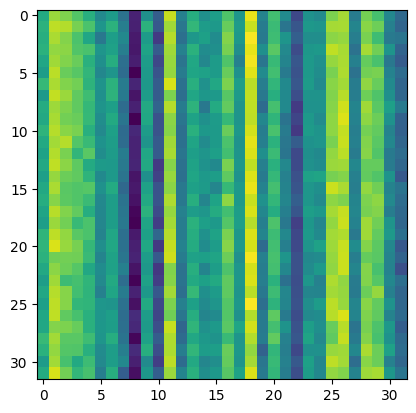

In [15]:
import matplotlib.pyplot as plt
plt.imshow(Y[0].mean(dim=-1).detach())

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from model.tokenizer import CausalTokenizerDecoder, CausalTokenizerEncoder, CausalTokenizerConfig, TokensToImageHead, ImagePatchifier
from model.utils import TokenMasker

cfg = CausalTokenizerConfig(
    num_modality_tokens=256,
    num_latent_tokens=32,
    max_context_length=192,
    model_dim=128,
    latent_dim=128,
    enc_num_layers=8, # Number of BlockCausalLayers (Each block has 3 spatial and 1 temporal layer)
    dec_num_layers=2, # Number of BlockCausalLayers (Each block has 3 spatial and 1 temporal layer)
    n_heads=8,
    n_kv_heads=4,
    dropout_prob=0.0,
    qk_norm=True,
    patch_size = 14,
)
encoder = CausalTokenizerEncoder(cfg)
decoder = CausalTokenizerDecoder(cfg)
patchifier = ImagePatchifier(cfg.patch_size, cfg.model_dim)
image_head = TokensToImageHead(cfg.model_dim, (224, 224), 14)
masker = TokenMasker(cfg.model_dim, cfg.num_modality_tokens)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ------------------------------------------------------------------------------
#   Building blocks: ResnetBlock2D + Upsample block (Stable Diffusion style)
# ------------------------------------------------------------------------------

class ResnetBlock2D(nn.Module):
    def __init__(self, channels, num_groups=8):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return x + h

class Upsample2D(nn.Module):
    """
    Upsample ×2 using SD-style: Conv with PixelShuffle OR nearest+conv.
    PixelShuffle gives sharper output with fewer artifacts.
    """
    def __init__(self, channels, factor=2):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.pixelshuffle = nn.PixelShuffle(factor)

    def forward(self, x):
        return self.pixelshuffle(F.silu(self.conv(x)))

class TokensToImageHead(nn.Module):
    def __init__(
        self,
        model_dim,
        img_size,
        patch_size,
        hidden_dim_multiplier=1,
        num_res_blocks=4,
        out_channels=3,
    ):
        super().__init__()

        self.H, self.W = img_size
        self.patch_size = patch_size

        self.h_patches = self.H // patch_size
        self.w_patches = self.W // patch_size

        hidden_dim = model_dim * hidden_dim_multiplier

        # Token → spatial map
        self.proj = nn.Conv2d(model_dim, hidden_dim, kernel_size=1)

        # Residual refinement blocks
        self.resblocks = nn.Sequential(
            *[ResnetBlock2D(hidden_dim) for _ in range(num_res_blocks)]
        )

        # Upsample ×2 (H/p → H)
        self.upsample = Upsample2D(hidden_dim)

        # Post-upsampling refinement
        self.post_resblocks = nn.Sequential(
            *[ResnetBlock2D(hidden_dim // 4) for _ in range(num_res_blocks // 2)]
        )

        # Final projection to RGB
        self.final_conv = nn.Sequential(
            nn.GroupNorm(32, hidden_dim // 4),
            nn.SiLU(),
            nn.Conv2d(hidden_dim // 4, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        x: (B, T, D)
        """
        B, T, D = x.shape
        assert T == self.h_patches * self.w_patches, "Token count mismatch."

        # 1. Tokens → spatial feature map
        x = x.transpose(1, 2).reshape(B, D, self.h_patches, self.w_patches)
        # 2. Project into convolutional feature space
        x = self.proj(x)

        # 3. Residual refinement at low resolution
        x = self.resblocks(x) 
        # 4. Upsample to full image resolution
        x = self.upsample(x)

        # 5. Additional refinement at full resolution
        x = self.post_resblocks(x)

        # 6. Final RGB
        return self.final_conv(x)
    
image_head = TokensToImageHead(cfg.model_dim, (224, 224), 14)

In [2]:
B = 4
T = 3 
H, W = 224, 224
imgs = torch.ones(B, T, 3, H, W)
modality = patchifier(imgs)
modality = masker(modality)
latents, patch_embeddings = encoder(modality)
modality_tokens=decoder(latents)

In [3]:
imgs_recon = image_head(modality_tokens)
imgs_recon.shape

torch.Size([4, 3, 3, 224, 224])

In [6]:
masked = masker(modality)

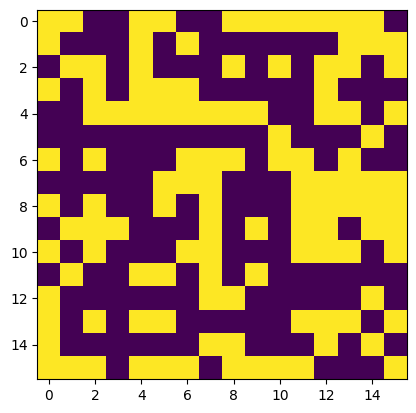

In [7]:
import matplotlib.pyplot as plt
mask_img = masked.sum(dim=-1).view(B, T, 16,16)[0]
plt.imshow(mask_img[2].detach())

## Attention Pattern Verification

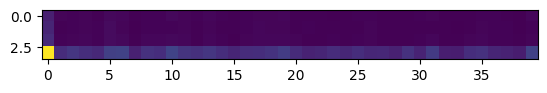

In [5]:
import matplotlib.pyplot as plt
x2 = x.clone()
x2[:, -1, 0, :] = 0 # Modalities can only attend to themselves and in the current timestep and the past --> chaning the latent should not affect the output of 

Y1_emb, Y1_patch = encoder(x)
Y2_emb, Y2_patch = encoder(x2)

Y1 = torch.cat([Y1_patch, Y1_emb], dim=2)
Y2 = torch.cat([Y2_patch, Y2_emb], dim=2)

diff = (Y1 - Y2).norm(dim=-1)
plt.imshow(diff[0].detach().cpu().numpy())

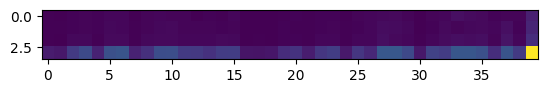

In [8]:
import matplotlib.pyplot as plt
x2 = x.clone()
x2[:, -1, -1, :] = 0 # Modalities can only attend to themselves and in the current timestep and the past --> chaning the latent should not affect the output of 

Y1 = decoder(x)
Y2 = decoder(x2)

diff = (Y1 - Y2).norm(dim=-1)
plt.imshow(diff[0].detach().cpu().numpy())

In [76]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from dataclasses import dataclass
from model.blocks import EfficientTransformerBlock



from model.dynamics import DreamerV4Denoiser, DreamerV4DenoiserCfg
from model.dynamics import ForwardDiffusionWithShortcut   

In [77]:
def ramp_weight(tau):
    """
    tau: (B, T, 1, 1), in [0, 1]
    returns: (B, T, 1, 1)
    """
    return 0.9 * tau + 0.1   # Eq. (8): w(τ) = 0.9 τ + 0.1


class ForwardDiffusionWithShortcut(nn.Module):
    """
    Dyadic shortcut schedule with per-frame (τ_t, d_t).

    K_max must be a power of 2, e.g. 32 or 64.
    Finest step size: d_min = 1 / K_max.
    """

    def __init__(self, K_max=32):
        super().__init__()
        assert (K_max & (K_max - 1)) == 0, "K_max must be a power of 2"
        self.K_max = int(K_max)
        self.max_pow2 = int(math.log2(self.K_max))   # e.g. K_max=32 -> max_pow2=5
        self.d_min = 1.0 / float(self.K_max)         # finest step

    def sample_step_noise(self, batch_size, seq_len, device):
        """
        Returns per-frame diffusion parameters:

          step          : (B, T) float   d_t ∈ {1, 1/2, ..., 1/K_max}
          step_index    : (B, T) long    k_t  ∈ {0, ..., log2(K_max)}  where d_t = 1 / 2^{k_t}
          tau           : (B, T) float   τ_t ∈ {0, d_t, 2 d_t, ..., 1 - d_t}
          tau_index     : (B, T) long    τ_t index on finest grid: τ_t = tau_index * d_min
          half_step_idx : (B, T) long    index for d_t/2 (not used when d_t = d_min)
          tau_plus_half : (B, T) long    index for τ_t + d_t/2 on finest grid
        """
        B, T = batch_size, seq_len

        # k_t ∈ {0, ..., max_pow2}, step d_t = 1 / 2^{k_t}
        step_index = torch.randint(
            low=0,
            high=self.max_pow2 + 1,
            size=(B, T),
            device=device,
            dtype=torch.long,
        )                              # (B, T)
        step = 1.0 / (2.0 ** step_index.float())     # (B, T) float, d_t

        # number of τ grid points for this d_t is 1/d_t = 2^{k_t}
        num_levels = (2 ** step_index).float()       # (B, T) float

        # sample m_t ∈ {0, ..., 2^{k_t} - 1} per frame
        m = torch.floor(
            torch.rand(B, T, device=device) * 0.9999 * num_levels
        ).long()                                     # (B, T) long

        tau = m.float() * step                       # (B, T) float, τ_t ∈ {0, d_t, ..., 1-d_t}

        # discrete τ index on finest grid of size K_max
        tau_index = torch.round(tau / self.d_min).long()
        tau_index = tau_index.clamp(0, self.K_max - 1)  # (B, T) long

        # half-step index: d_t/2 corresponds to k_t + 1 (smaller step),
        # but clamp to max_pow2 to stay in range (unused when d_t = d_min).
        half_step_index = (step_index + 1).clamp(max=self.max_pow2)  # (B, T) long

        # on finest grid, stride for this d_t is K_max * d_t = 2^{max_pow2 - k_t}
        stride = (self.K_max // (2 ** step_index)).long()            # (B, T) long
        delta_tau_index = (stride // 2)                              # corresponds to d_t/2

        tau_plus_half_index = tau_index + delta_tau_index            # τ_t + d_t/2
        tau_plus_half_index = tau_plus_half_index.clamp(0, self.K_max - 1)

        return dict(
            step=step,                          # (B, T) float
            step_index=step_index,              # (B, T) long
            tau=tau,                            # (B, T) float
            tau_index=tau_index,                # (B, T) long
            half_step_index=half_step_index,    # (B, T) long
            tau_plus_half_index=tau_plus_half_index,  # (B, T) long
        )

    def forward(self, z_clean):
        """
        z_clean: (B, T, N_lat, D_latent)  # clean latents (x = z_1)
        """
        B, T, N_lat, D_lat = z_clean.shape
        device = z_clean.device

        # Sample z_0 ~ N(0, I) in latent space
        z0 = torch.randn_like(z_clean)                      # (B, T, N_lat, D_lat)

        diff = self.sample_step_noise(B, T, device)

        tau = diff["tau"].unsqueeze(-1).unsqueeze(-1)       # (B, T, 1, 1)
        step = diff["step"].unsqueeze(-1).unsqueeze(-1)     # (B, T, 1, 1)

        # z_τ = (1 - τ) z_0 + τ z_1
        z_tau = (1.0 - tau) * z0 + tau * z_clean            # (B, T, N_lat, D_lat)

        return {
            "x": z_clean,                        # (B, T, N_lat, D_lat)  clean z_1
            "x_tau": z_tau,                      # (B, T, N_lat, D_lat)  noisy z_τ
            "tau": diff["tau"],                  # (B, T) float
            "step": diff["step"],                # (B, T) float
            "tau_index": diff["tau_index"],      # (B, T) long
            "step_index": diff["step_index"],    # (B, T) long
            "half_step_index": diff["half_step_index"],          # (B, T) long
            "tau_plus_half_index": diff["tau_plus_half_index"],  # (B, T) long
            "d_min": self.d_min,                 # scalar float
            "K_max": self.K_max,
        }

In [78]:
cfg = DreamerV4DenoiserCfg(
    num_action_tokens = 32,
    num_latent_tokens = 512,
    num_register_tokens = 16,
    max_context_length = 128,
    model_dim = 128,
    latent_dim = 16,
    n_layers = 4,
    n_heads = 4,
)
denoiser = DreamerV4Denoiser(cfg)
forward_diffuser = ForwardDiffusionWithShortcut(K_max=16)

In [79]:
x = torch.rand(1, 1024, 512, 16)

In [80]:
diff_step = torch.ones(1, 2)*0
shortcut = torch.ones(1, 2)*0
denoiser(x, diff_step, shortcut).shape

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1024 but got size 2 for tensor number 2 in the list.

In [75]:
info = forward_diffuser(x)
info.keys()
info['half_step_index'].max()

tensor(4)

In [6]:
info['step'].shape

torch.Size([1, 2])

In [ ]:
# def apply_denoiser(denoiser, z_tau, tau, step, no_grad=False):
#     if no_grad:
#         with torch.no_grad():
#             z_hat =  denoiser(z_tau, tau, step)
#         return z_hat
#     else:
#         return denoiser(z_tau, tau, step)

def apply_denoiser(denoiser, x_tau, tau_index, step_index, act_tokens=None, no_grad=False):
    """
    denoiser   : DreamerV4Denoiser
    x_tau      : (B, T, N_lat, D_latent)
    tau_index  : (B, T) long        # discrete τ index in [0, K_max-1]
    step_index : (B, T) long        # discrete d index in [0, log2(K_max)]
    act_tokens : (B, T, N_act, D_model) or None

    returns:
      z_hat: (B, T, N_lat, D_latent)
    """
    if no_grad:
        with torch.no_grad():
            return denoiser(
                latent_tokens=x_tau,          # (B, T, N_lat, D_latent)
                diffusion_step=tau_index,     # (B, T)
                shortcut_length=step_index,   # (B, T)
                act_token=act_tokens,
                causal=True,
            )
    else:
        return denoiser(
            latent_tokens=x_tau,
            diffusion_step=tau_index,
            shortcut_length=step_index,
            act_token=act_tokens,
            causal=True,
        )

In [8]:
z_hat = apply_denoiser(denoiser, info['x_tau'], info['tau_d'], info['step_d'], no_grad=True)
z_hat.shape

torch.Size([1, 2, 512, 16])

In [ ]:
def compute_bootstrap_diffusion_loss(info, denoiser, act_tokens=None):
    """
    info: dict from ForwardDiffusionWithShortcut.forward, with keys:
      x                  : (B, T, N_lat, D_latent)
      x_tau              : (B, T, N_lat, D_latent)
      tau                : (B, T) float
      step               : (B, T) float
      tau_index          : (B, T) long
      step_index         : (B, T) long
      half_step_index    : (B, T) long
      tau_plus_half_index: (B, T) long
      d_min              : scalar float

    denoiser : DreamerV4Denoiser
    act_tokens: optional action tokens, (B, T, N_act, D_model)

    returns:
      flow_loss      : scalar (flow branch, d = d_min)
      bootstrap_loss : scalar (bootstrap branch, d > d_min)
    """
    x = info["x"]                          # (B, T, N_lat, D_latent)
    x_tau = info["x_tau"]                  # (B, T, N_lat, D_latent)
    tau = info["tau"]                      # (B, T) float
    step = info["step"]                    # (B, T) float
    tau_index = info["tau_index"]          # (B, T) long
    step_index = info["step_index"]        # (B, T) long
    half_step_index = info["half_step_index"]          # (B, T) long
    tau_plus_half_index = info["tau_plus_half_index"]  # (B, T) long
    d_min = info["d_min"]                  # scalar float

    B, T, N_lat, D_lat = x.shape

    tau_b = tau.view(B, T, 1, 1)           # (B, T, 1, 1)
    step_b = step.view(B, T, 1, 1)         # (B, T, 1, 1)

    # -------- Big-step prediction: \hat z_1 --------
    # Eq. 7: f_θ(z_τ, τ, d, a) in x-space
    z_hat = apply_denoiser(
        denoiser,
        x_tau,                 # (B, T, N_lat, D_lat)
        tau_index,             # (B, T)
        step_index,            # (B, T)
        act_tokens=act_tokens,
        no_grad=False,
    )                           # -> (B, T, N_lat, D_lat)

    # ======================================================
    # 1) Flow loss branch (d = d_min): || ẑ_1 - z_1 ||^2
    # ======================================================
    flow_residual = z_hat - x                  # (B, T, N_lat, D_lat)
    flow_sq = flow_residual.pow(2).mean(dim=(-1, -2))  # (B, T), avg over tokens & dims

    mask_small = (step == d_min).float()       # (B, T), 1 where d_t == d_min else 0

    # ramp weight w(τ) from Eq. (8)
    w_tau = ramp_weight(tau_b).view(B, T)      # (B, T)

    flow_loss_per = w_tau * flow_sq * mask_small    # (B, T)
    denom_flow = mask_small.sum().clamp_min(1.0)    # avoid div by 0
    flow_loss = flow_loss_per.sum() / denom_flow    # scalar

    # ======================================================
    # 2) Bootstrap branch (d > d_min):
    #    v_target = (b1 + b2)/2, with
    #    b1 = [f(z_τ, τ, d/2) - z_τ] / (1 - τ)
    #    b2 = [f(z', τ + d/2, d/2) - z'] / (1 - (τ + d/2))
    #    Loss: (1 - τ)^2 || v_hat - sg(v_target) ||^2
    # ======================================================
    with torch.no_grad():
        # ------- First half-step -------
        f1 = apply_denoiser(
            denoiser,
            x_tau,                   # (B, T, N_lat, D_lat)
            tau_index,               # (B, T)        τ
            half_step_index,         # (B, T)        d/2
            act_tokens=act_tokens,
            no_grad=True,
        )                            # (B, T, N_lat, D_lat)

        b1 = (f1 - x_tau) / (1.0 - tau_b)        # (B, T, N_lat, D_lat)

        # z' = z_τ + b1 * d/2
        z_prime = x_tau + b1 * (step_b / 2.0)    # (B, T, N_lat, D_lat)

        # ------- Second half-step -------
        f2 = apply_denoiser(
            denoiser,
            z_prime,                 # (B, T, N_lat, D_lat)
            tau_plus_half_index,     # (B, T)       τ + d/2
            half_step_index,         # (B, T)       d/2
            act_tokens=act_tokens,
            no_grad=True,
        )                            # (B, T, N_lat, D_lat)

        denom2 = 1.0 - (tau_b + step_b / 2.0)    # (B, T, 1, 1)
        b2 = (f2 - z_prime) / denom2             # (B, T, N_lat, D_lat)

        v_target = 0.5 * (b1 + b2)               # (B, T, N_lat, D_lat)  (sg via no_grad)

    # predicted velocity from big step:
    v_hat = (z_hat - x_tau) / (1.0 - tau_b)      # (B, T, N_lat, D_lat)

    boot_err = v_hat - v_target                  # (B, T, N_lat, D_lat)

    # x-space scaling (1 - τ)^2 and ramp weight w(τ)
    boot_sq = ((1.0 - tau_b) ** 2 * boot_err.pow(2)).mean(dim=(-1, -2))  # (B, T)

    mask_large = (step > d_min).float()          # (B, T)
    boot_loss_per = w_tau * boot_sq * mask_large

    denom_boot = mask_large.sum().clamp_min(1.0)
    bootstrap_loss = boot_loss_per.sum() / denom_boot

    return flow_loss, bootstrap_loss








def compute_bootstrap_diffusion_loss(info):
    step = info['step'].unsqueeze(-1).unsqueeze(-1)
    tau = info['tau'].unsqueeze(-1).unsqueeze(-1)
    z_hat = apply_denoiser(denoiser, info['x_tau'], info['tau_d'], info['step_d'], no_grad=False)
    with torch.no_grad():
        # first half-step
        f1 = apply_denoiser(denoiser, info['x_tau'], info['tau_d'], info['half_step_d'], no_grad=True)
        b_prime = (f1 - info['x_tau']) / (1. - tau)
        z_prime = info['x_tau'] + b_prime * (step / 2.)
        # second half-step
        f2 = apply_denoiser(denoiser, z_prime, info['tau_plus_half_step_d'], info['half_step_d'], no_grad=True)
        b_dprime = (f2 - z_prime) / (1. - tau - step / 2.)
        bootstrap_target = (b_dprime+b_prime)/2.
    
    flow_residual = z_hat-info['x']
    flow_error = torch.where(step > info['d_min'], 0., flow_residual)
    flow_loss = flow_error.pow(2).mean()

    bootstrap_residual = (z_hat-info['x_tau'])/(1.-tau) - bootstrap_target
    bootstrap_error = torch.where(step == info['d_min'], 0., bootstrap_residual) 
    bootstrap_loss = (((1.-tau)**2)*bootstrap_error.flatten(-2,-1).pow(2).mean(dim=-1)).mean()

    return flow_loss, bootstrap_loss

flow_loss, bootstrap_loss = compute_bootstrap_diffusion_loss(info)

In [39]:
loss = flow_loss + bootstrap_loss


In [27]:
a = torch.ones(4, 10)
b = torch.ones(4, 10)*0
torch.nn.functional.mse_loss(a, b), (a-b).pow(2).mean()

(tensor(1.), tensor(1.))

In [ ]:
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
img = Image.open('/Users/rooholla/Downloads/1.jpg')
img = img.resize((224, 224))
img = img.convert('L')
img = pil_to_tensor(img)/255
img.shape

torch.Size([1, 224, 224])

tensor([[ True,  True,  True,  True],
        [False,  True,  True,  True],
        [False,  True, False,  True],
        [False,  True,  True, False]])
torch.Size([11])


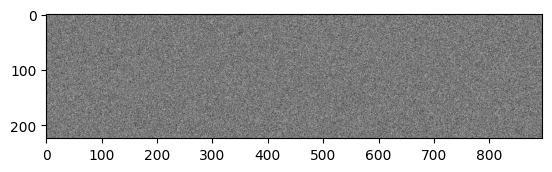

In [1613]:
out = df(img[None].repeat(4, 4,1,1))['x_tau']
plt.imshow(torch.hstack([out[0][i] for i in range(out.squeeze().shape[0])]), cmap='gray')